# Regression Dilution and Correlated Errors
[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/course_objective_analysis/tree/main/code)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eabarnes1010/course_objective_analysis/blob/main/code/lin_regression_with_errors.ipynb)

Dealing with regression dilution and correlated errors in x and y.

This notebook was inspired by a presentation given by Prof. Angie Pendergrass on Dec. 8, 2022 at CSU. Once the accompanying paper (Kao and Pendergrass, in prep) is submitted I will link to the paper here. Also, that work is supported by the original work of [York (1969)](https://www.sciencedirect.com/science/article/abs/pii/S0012821X68800597?via%3Dihub) and [Mahon (1996)](https://doi.org/10.1080/00206819709465336) as well as others.

In [1]:
%matplotlib inline

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
print('IN_COLAB = ' + str(IN_COLAB))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
# if IN_COLAB:
    # !pip install curefit
# from curefit import LinReg  # pip install curefit

#-------------------------------------------------------
# set figure defaults
mpl.rcParams['figure.dpi'] = 175
LW = 1.75
SEED = 55  # define the random seed

IN_COLAB = False


In [2]:
# curefit is no longer available on pip - so I have copied the class definition here

"""Linear Regression according to Mahon (1996) - corrected."""

from typing import Tuple, Union
import warnings

import numpy as np
from numpy.polynomial import Polynomial
import scipy.stats as stats
from scipy.stats.distributions import chi2


class LinReg:
    """Linear regression using (corrected) Mahon (1996) prescription.

    Example:
        >>> import numpy as np
        >>> from curefit import LinReg
        >>> # some data
        >>> xdata = np.array([1, 2, 3.1, 4.9])
        >>> ydata = np.array([1.1, 1.9, 3, 5.5])
        >>> # some uncertainty and correlation
        >>> xunc = 0.05 * xdata
        >>> yunc = 0.073 * ydata
        >>> rho = np.zeros_like(xdata) + 0.5
        >>> # do regression
        >>> my_reg = LinReg(xdata, xunc, ydata, yunc, rho)
        >>> # print out the parameters and their uncertainties
        >>> my_reg.slope
        (0.9983617286559998, 0.0684389236571533)
        >>> my_reg.intercept
        (0.05545339135826666, 0.11811730191506546)
        >>> my_reg.mswd
        2.5105964767246842
    """

    def __init__(
        self,
        xdat: np.ndarray,
        sigx: np.ndarray,
        ydat: np.ndarray,
        sigy: np.ndarray,
        rho: Union[float, np.ndarray] = None,
        fixpt: np.ndarray = None,
        autocalc=True,
        **kwargs,
    ):
        """Initialize the class.

        :param xdat: X data.
        :param ydat: Y data.
        :param sigx: 1 sigma uncertainty of x data.
        :param sigy: 1 sigma uncertainty of y data.
        :param rho: Correlation between x and y data, defaults to no correlation.
        :param fixpt: Fixed point through which regression needs to go.
        :param autocalc: Automatically calculate the regression and print params.
        :param kwargs: Additional keyword arguments:
            "iter_max": Maximum iteration limit for slope (default 1e6)
            "reg_limit": Regression limit for slope (default: 1e-6)

        :raises ValueError: Fix point is of the wrong shape.
        """
        self.xdat = np.array(xdat)
        self.sigx = np.array(sigx)
        self.ydat = np.array(ydat)
        self.sigy = np.array(sigy)
        if rho is None:
            self.rho = np.zeros_like(self.xdat)
        else:
            self.rho = np.array(rho)

        # calculate correlated uncertainty sigxy
        self.sigxy = self.rho * self.sigx * self.sigy

        if fixpt is not None:
            fixpt = np.array(fixpt)
            if fixpt.shape != (2,):
                raise ValueError("Fix point must be of the form [x_fix, yfix].")
        self.fix_pt = fixpt

        # Initialize the parameters to be returned
        self._dof = None
        self._slope = None
        self._slope_unc = None
        self._intercept = None
        self._intercept_unc = None
        self._chi_squared = None
        self._mswd = None

        # keyword arguments
        if "regression_limit" in kwargs:
            self.reg_limit = kwargs["regression_limit"]
        else:
            self.reg_limit = 1e-6
        if "iter_max" in kwargs:
            self.iter_max = kwargs["iter_max"]
        else:
            self.iter_max = 1e6

        # helper variables
        self.xbar = None
        self.ybar = None
        self.weights = None

        if autocalc:
            self.calculate()

    @property
    def chi_squared(self) -> float:
        """Return chi_squared of the regression."""
        return self._chi_squared

    @property
    def dof(self) -> int:
        """Return the degrees of freedom of the system."""
        return self._dof

    @property
    def intercept(self) -> Tuple[float, float]:
        """Return intercept and its 1 sigma uncertainty."""
        return self._intercept, self._intercept_unc

    @property
    def mswd(self) -> float:
        """Return MSWD of the regression."""
        return self._mswd

    @property
    def parameters(self) -> np.ndarray:
        """Return all parameters of the linear regression.

        :return: slope, slope_uncertainty, intercept, intercept_uncertainty, MSWD
        """
        return np.array(
            [
                self._slope,
                self._slope_unc,
                self._intercept,
                self._intercept_unc,
                self._mswd,
            ]
        )

    @property
    def slope(self) -> Tuple[float, float]:
        """Return slope and its 1 sigma uncertainty."""
        return self._slope, self._slope_unc

    def calculate(self):
        """Do the linear regression and save the parameters in the class variables."""
        self.slope_initial_guess()
        self.slope_calculation()
        self.intercept_calculation()
        self.unc_calculation()
        self.goodness_of_fit()

    def confidence_intervals(
        self,
        p_conf: float = 0.95,
        xrange: np.ndarray = None,
        bins: int = 100,
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Calculate the confidence intervals and return them.

        :param p_conf: Confidence interval, default 95% (``p_conf=0.95``).
        :param xrange: Range from where to where to calculate CI. Default ``None``.
            If None, defaults to min and max of x values that are defined.
        :param bins: Number of bins to calculate, defaults to 100.

        :return: Data to plot CI: xdata, y_ci_minimum, y_ci_maximum
        """
        xax_ci, yax_ub_min, yax_ub_max = self.uncertainty_band(
            sigma=1, xrange=xrange, bins=bins
        )

        yax_ci = np.abs(yax_ub_max - yax_ub_min) / 2.0

        # now create the confidence interval that we need for double tailed distribution
        zfac = stats.t.ppf(1 - (1 - p_conf) / 2.0, len(self.xdat) - 2)
        yax_ci *= zfac

        yax_ci_min = xax_ci * self.slope[0] + self.intercept[0] - yax_ci
        yax_ci_max = xax_ci * self.slope[0] + self.intercept[0] + yax_ci

        return xax_ci, yax_ci_min, yax_ci_max

    def goodness_of_fit(self):
        """Calculate goodness of fit parameters chi-squared and MSWD."""
        chi_sq = np.sum(
            self.weights * (self.ydat - self._slope * self.xdat - self._intercept) ** 2
        )
        self._chi_squared = chi_sq

        dof = len(self.xdat) - 2 if self.fix_pt is None else len(self.xdat) - 1
        self._dof = dof
        self._mswd = chi_sq / dof

    def intercept_calculation(self):
        """Calculate the intercept."""
        self._intercept = self.ybar - self._slope * self.xbar

    def mswd_ci(self, p_conf=0.95) -> Tuple[float, float]:
        """Calculate confidence interval of MSWD value given degrees of freedom of.

        :param p_conf: Confidence level, defaults to 0.95 (95%)

        :return: Confidence interval for the MSWD inside this interval.
        """
        dof = self.dof
        right_tail = 1 - (1 - p_conf) / 2
        left_tail = 1 - right_tail
        mswd_lower = chi2.ppf(left_tail, dof) / dof
        mswd_upper = chi2.ppf(right_tail, dof) / dof
        return mswd_lower, mswd_upper

    def slope_calculation(self):
        """Iterate the slope until it fits."""

        def calc_weights(b: float):
            """Calculate weights and return them.

            :param b: Slope

            :return: Weights
            """
            return 1 / (self.sigy**2 + b**2 * self.sigx**2 - 2 * b * self.sigxy)

        def calc_xbar(weights: np.ndarray):
            """Calculate x bar and return it.

            :param weights: Weights.

            :return: X bar.
            """
            if self.fix_pt is None:
                return np.sum(weights * self.xdat) / np.sum(weights)
            else:
                return self.fix_pt[0]

        def calc_ybar(weights: np.ndarray):
            """Calculate y bar and return it.

            :param weights: Weights.

            :return: Y bar.
            """
            if self.fix_pt is None:
                return np.sum(weights * self.ydat) / np.sum(weights)
            else:
                return self.fix_pt[1]

        def iterate_b(b_old):
            """Do one iteration step with the slope and return the new value."""
            b = b_old
            weights = calc_weights(b)
            u_all = self.xdat - calc_xbar(weights)
            v_all = self.ydat - calc_ybar(weights)
            b_new = np.sum(
                weights**2
                * v_all
                * (
                    u_all * self.sigy**2
                    + b * v_all * self.sigx**2
                    - v_all * self.sigxy
                )
            ) / np.sum(
                weights**2
                * u_all
                * (
                    u_all * self.sigy**2
                    + b * v_all * self.sigx**2
                    - b * u_all * self.sigxy
                )
            )
            return b_new

        # iterate until solution is found
        iter_cnt = 0
        b_old = self._slope
        b_new = iterate_b(b_old)
        while np.abs(b_old - b_new) > self.reg_limit and iter_cnt < self.iter_max:
            b_old = b_new
            b_new = iterate_b(b_old)
            iter_cnt += 1

        if iter_cnt >= self.iter_max:
            warnings.warn(
                f"Iteration count for slope optimization hit the limt at "
                f"{self.iter_max}. The current difference between the old and new "
                f"slope is {np.abs(b_old - b_new)}"
            )

        self._slope = b_new
        self.weights = calc_weights(b_new)
        self.xbar = calc_xbar(self.weights)
        self.ybar = calc_ybar(self.weights)

    def slope_initial_guess(self):
        """Calculate an initial guess of the slope without uncertainties and save it."""
        polyfit = Polynomial.fit(self.xdat, self.ydat, deg=1)
        self._slope = polyfit.convert().coef[1]

    def uncertainty_band(
        self,
        sigma=1,
        xrange: np.ndarray = None,
        bins: int = 100,
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Calculate the uncertainty bands and return them.

        :param sigma: How many sigma should the band be? Default: 1
        :param xrange: Range from where to where to band. Default ``None``.
            If None, defaults to min and max of x values that are defined.
        :param bins: Number of bins to calculate, defaults to 100.

        :return: Data to plot band: xdata, y_ub_minimum, y_ub_maximum
        """
        if xrange is None:
            xax_ci = np.linspace(np.min(self.xdat), np.max(self.xdat), bins)
        else:
            xax_ci = np.linspace(xrange[0], xrange[1], bins)

        xdat_save = self.xdat.copy()

        yax_ub = np.zeros(bins)
        for it, deltax in enumerate(xax_ci):
            self.xdat = xdat_save - deltax
            self.slope_initial_guess()
            self.slope_calculation()
            self.intercept_calculation()
            self.unc_calculation()
            yax_ub[it] = self.intercept[1]

        # mulitply with sigma
        yax_ub *= sigma

        # reset all calculations
        self.xdat = xdat_save
        self.calculate()

        yax_ub_min = xax_ci * self.slope[0] + self.intercept[0] - yax_ub
        yax_ub_max = xax_ci * self.slope[0] + self.intercept[0] + yax_ub

        return xax_ci, yax_ub_min, yax_ub_max

    def unc_calculation(self):
        """Calculate uncertainties for slope and intercept with no fixed point."""
        # helper variables
        sigx = self.sigx
        sigy = self.sigy
        sigxy = self.sigxy
        b = self._slope
        weights = self.weights
        xbar = self.xbar
        ybar = self.ybar
        u_all = self.xdat - xbar
        v_all = self.ydat - ybar

        sum_weights = np.sum(weights)

        # d(theta) / db
        dthdb = np.sum(
            weights**2
            * (
                2 * b * (u_all * v_all * sigx**2 - u_all**2 * sigxy)
                + (u_all**2 * sigy**2 - v_all**2 * sigx**2)
            )
        ) + 4 * np.sum(
            weights**3
            * (sigxy - b * sigx**2)
            * (
                b**2 * (u_all * v_all * sigx**2 - u_all**2 * sigxy)
                + b * (u_all**2 * sigy**2 - v_all**2 * sigx**2)
                - (u_all * v_all * sigy**2 - v_all**2 * sigxy)
            )
        )

        def calc_dtheta_dxi(it: int):
            """Calculate partial derivative d(theta)/dxi.

            :param it: Index where the $i$ is at.

            :return: dtheta/dxi
            """
            if self.fix_pt is None:
                sum_all = 0.0
                for jt, wj in enumerate(weights):
                    kron = kron_delta(it, jt)
                    sum_all += (
                        wj**2
                        * (kron - weights[it] / sum_weights)
                        * (
                            b**2 * v_all[jt] * sigx[jt] ** 2
                            - b**2 * 2 * u_all[jt] * sigxy[jt]
                            + 2 * b * u_all[jt] * sigy[jt] ** 2
                            - v_all[jt] * sigy[jt] ** 2
                        )
                    )
                return sum_all
            else:
                return weights[it] ** 2 * (
                    b**2 * v_all[it] * sigx[it] ** 2
                    - b**2 * 2 * u_all[it] * sigxy[it]
                    + 2 * b * u_all[it] * sigy[it] ** 2
                    - v_all[it] * sigy[it] ** 2
                )

        def calc_dtheta_dyi(it: int):
            """Calculate partial derivative d(theta)/dyi.

            :param it: Index where the $i$ is at.

            :return: dtheta/dyi
            """
            if self.fix_pt is None:
                sum_all = 0.0
                for jt, wj in enumerate(weights):
                    kron = kron_delta(it, jt)
                    sum_all += (
                        wj**2
                        * (kron - weights[it] / sum_weights)
                        * (
                            b**2 * u_all[jt] * sigx[jt] ** 2
                            - 2 * b * v_all[jt] * sigx[jt] ** 2
                            - u_all[jt] * sigy[jt] ** 2
                            + 2 * v_all[jt] * sigxy[jt]
                        )
                    )
                return sum_all
            else:
                return weights[it] ** 2 * (
                    b**2 * u_all[it] * sigx[it] ** 2
                    - 2 * b * v_all[it] * sigx[it] ** 2
                    - u_all[it] * sigy[it] ** 2
                    + 2 * v_all[it] * sigxy[it]
                )

        def calc_da_dxi(it: int):
            """Calculate partial derivative da/dxi.

            This routine is only used when no fixed point is selected.

            :param it: Index where the $i$ is at.

            :return: da/dxi
            """
            return -b * weights[it] / sum_weights - xbar * calc_dtheta_dxi(it) / dthdb

        def calc_da_dyi(it: int):
            """Calculate partial derivative da/dyi.

            This routine is only used when no fixed point is selected.

            :param it: Index where the $i$ is at.

            :return: da/dyi
            """
            return weights[it] / sum_weights - xbar * calc_dtheta_dyi(it) / dthdb

        # calculate uncertainty for slope
        sigb_sq = 0.0
        for it, sigxi in enumerate(sigx):
            sigyi = sigy[it]
            sigxyi = sigxy[it]
            dtheta_dxi = calc_dtheta_dxi(it)
            dtheta_dyi = calc_dtheta_dyi(it)
            sigb_sq += (
                dtheta_dxi**2 * sigxi**2
                + dtheta_dyi**2 * sigyi**2
                + 2 * sigxyi * dtheta_dxi * dtheta_dyi
            )
        sigb_sq /= dthdb**2
        self._slope_unc = np.sqrt(sigb_sq)

        if self.fix_pt is None:
            siga_sq = 0.0
            for it, sigxi in enumerate(sigx):
                sigyi = sigy[it]
                sigxyi = sigxy[it]
                da_dxi = calc_da_dxi(it)
                da_dyi = calc_da_dyi(it)
                siga_sq += (
                    da_dxi**2 * sigxi**2
                    + da_dyi**2 * sigyi**2
                    + 2 * sigxyi * da_dxi * da_dyi
                )
        else:
            siga_sq = self.fix_pt[0] ** 2 * sigb_sq
        self._intercept_unc = np.sqrt(siga_sq)

    def regression_line(
        self, xrange: np.ndarray = None
    ) -> Tuple[np.ndarray, np.ndarray]:
        """Return xdata and ydata for the calculated regression line for plotting.

        :param xrange: Range for which to calculate the regression. Default: ``None``.
            If None, defaults to min and max of x values that are defined.

        :return: xdata to plot, ydata to plot regression line.
        """
        if xrange is None:
            xrange = np.array([self.xdat.min(), self.xdat.max()])

        ydat = self._slope * xrange + self._intercept
        return xrange, ydat


def kron_delta(
    ind1: Union[int, np.ndarray], ind2: Union[int, np.ndarray]
) -> Union[int, np.ndarray]:
    """Calculate Kronecker-delta for variables i,j.

    Compare two indexes and return 0 if the same, otherwise 1. If an ndarray is given,
    return an ndarray comparing each index individually.

    :param ind1: Index(es)
    :param ind2: Index(es)

    :return: 1 if ind 1 is identical to ind2, otherwise 0

    :raises ValueError: The input indexes have different shape.
    """
    if np.shape(ind1) != np.shape(ind2):
        raise ValueError("The inputs must have the same shape.")

    if np.shape(ind1) == ():  # don't have arrays
        return 1 if ind1 == ind2 else 0
    else:
        ret_arr = np.zeros_like(ind1)
        ret_arr[np.where(ind1 == ind2)] = 1
        return ret_arr


# Regression Dilution

First, let's make two data sets x and y that both have errors, but these errors are uncorrelated. Below we show that standard ordinary least squares regression does a very poor job estimating the slope in this case as it assumes that only y has errors (i.e. it assumes that x does not have errors). We can then use York regression to fit again (but we can use the fact that we know the errors in x and y are uncorrelated).

slope_true = 1.0
est. slope_xynoise = 0.66
est. york_slope = (1.0403756337760581, 0.04622092949146436)


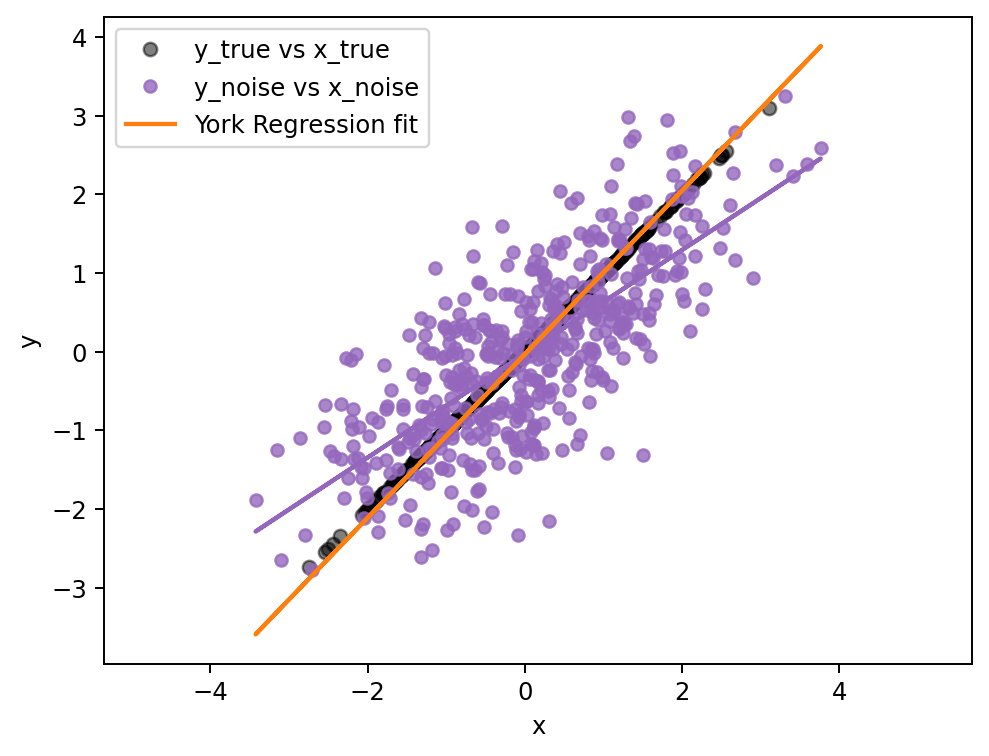

In [3]:
#---------------------------------------------------------------------------
rng = np.random.default_rng(SEED+1)  # set random seed to get reproducible results
N = 500  # number of samples
slope_true = 1.0  # slope of the true best fit line
sigma_y = 0.44  # amplitude of y-error
sigma_x = 0.75  # amplitude of x-error
std_X = 1.0     # spread of the noise-less x-values
#---------------------------------------------------------------------------

# CREATE X DATA
x = std_X*np.random.normal(size=N)
x_noise = sigma_x*rng.normal(size=len(x))
x_obs = x + x_noise

# CREATE Y DATA BASED ON X but with UNCORRELATED ERRORS
y = slope_true * x
y_noise = sigma_y*rng.normal(size=len(x))
y_obs = y + y_noise

# FIT REGRESSION LINE
slope_xynoise, intercept_noise, __, __, __ = stats.linregress(x_obs,y_obs)
slope_xynoise = slope_xynoise.round(2)

# FIT YORK REGRESSION LINE
york_fit = LinReg(x_obs, sigma_x*np.ones(x_noise.shape), y_obs, sigma_y*np.ones(y.shape), rho=0.0)
york_slope = york_fit.slope

print(f"{slope_true = }")
print(f"est. {slope_xynoise = }")
print(f"est. {york_slope = }")

plt.figure()
plt.plot(x,y,'.', color="k", markersize=11, label=f"y_true vs x_true", alpha=.5)
plt.plot(x_obs, y_obs,'.', color="tab:purple", markersize=10, label=f"y_noise vs x_noise", alpha=.8)
plt.plot(x_obs, slope_xynoise*x_obs+intercept_noise, '-', color="tab:purple", linewidth=LW)
plt.plot(x_obs, x_obs*york_slope[0] + york_fit.intercept[0], '-', color='tab:orange', linewidth=LW, label='York Regression fit')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.axis('equal')
plt.show()


Now let's repeat this 10,000 times for lots of different data and best-fit lines. As we discussed in class, we can compute the theoretical average error that regression dilution will cause. Let's see if it works.

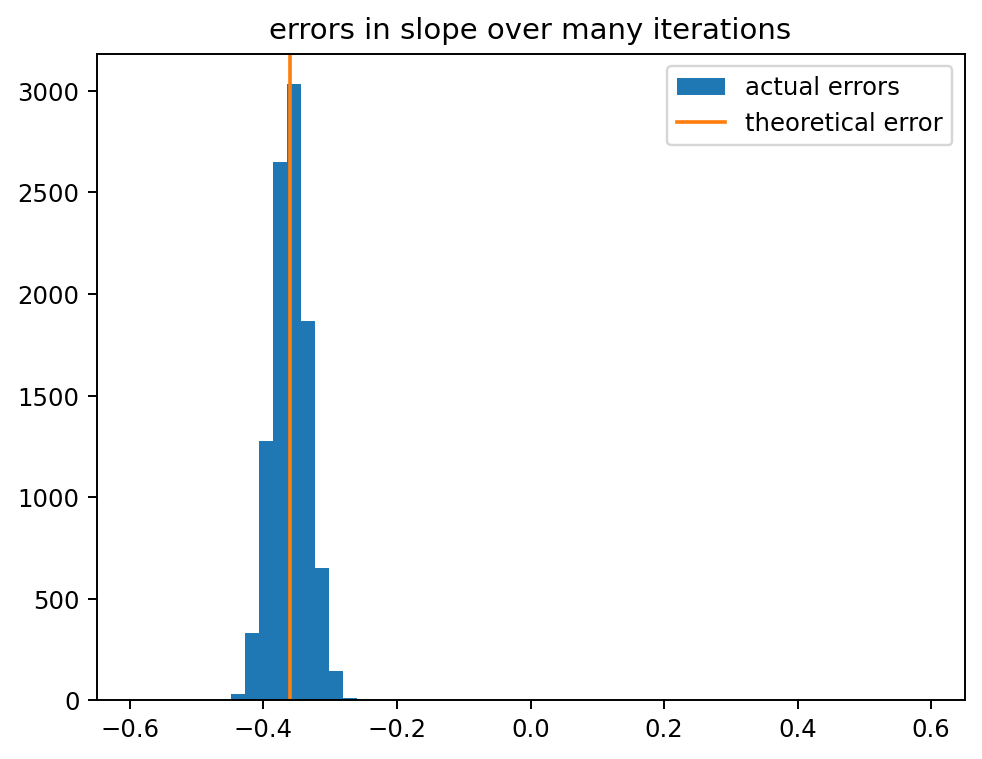

theoretical error = -0.36
average error     = -0.3599420677097758


In [4]:
#---------------------------------------------------------------------------
rng = np.random.default_rng(SEED+2)  # set random seed to get reproducible results
N = 500  # number of samples
slope_true = 1.0  # slope of the true best fit line
sigma_y = 0.44  # amplitude of y-error
sigma_x = 0.75  # amplitude of x-error
std_X = 1.0     # spread of the noise-less x-values
niters = 10_000
#---------------------------------------------------------------------------

slope_vec = np.zeros((niters,))
for i in np.arange(0,niters):

    # CREATE TRUTH X DATA
    x = std_X*np.random.normal(size=N)

    # ONLY Y HAS NOISE
    y = slope_true * x
    y_noise = sigma_y*rng.normal(size=len(x))
    y_obs = y + y_noise

    # X AND Y BOTH HAVE UNCORRELATED NOISE
    x_noise = sigma_x*rng.normal(size=len(x))
    x_obs = x + x_noise
    slope_xynoise, intercept_noise, __, __, __ = stats.linregress(x_obs,y_obs)
    slope_vec [i] = slope_xynoise - slope_true

theory_error = slope_true * ((std_X**2) / (std_X**2 + sigma_x**2) - 1 )

plt.hist(slope_vec, label="actual errors")
plt.axvline(x=theory_error, color="tab:orange", label="theoretical error")
plt.title('errors in slope over many iterations')
plt.legend()
plt.xlim(-.65,.65)
plt.show()

print(f"theoretical error = {theory_error}")
print(f"average error     = {np.mean(slope_vec)}")

Wow! It definitely works. That is awesome.

# Correlated errors in x and y

Now, let's repeat the process but all the errors in x and the errors in y to be correlated with one another.

slope_true = 1.0
est. slope_xynoise = 0.51
est. york_slope = (1.0252231302077328, 0.05488116641143792)


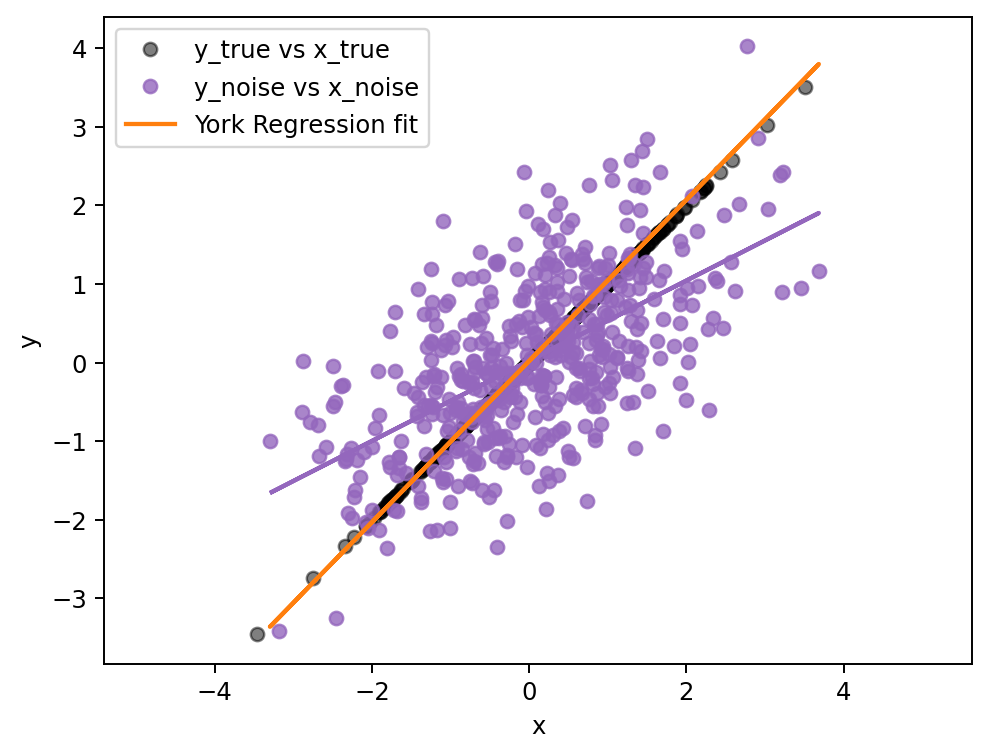

In [5]:
#---------------------------------------------------------------------------
LW = 1.75
rng = np.random.default_rng(SEED)  # set random seed to get reproducible results
N = 500  # number of samples
r_xy = -.35  # correlation of x and y noise
slope_true = 1.0  # slope of the true best fit line
sigma_y = 0.44  # amplitude of y-error
sigma_x = 0.75  # amplitude of x-error
std_X = 1. # spread of the noise-less x-values
#---------------------------------------------------------------------------

# DEFINE THE CORRELATED NOISE
mean = [0, 0]
cov = [[sigma_x**2, r_xy*sigma_x*sigma_y], [r_xy*sigma_x*sigma_y, sigma_y**2]]
x_noise, y_noise = rng.multivariate_normal(mean, cov, N).T

# CREATE TRUTH X DATA
x = std_X*np.random.normal(size=N)
x_obs = x + x_noise

# ONLY Y HAS NOISE
y = slope_true * x
y_obs = y + y_noise

# X AND Y BOTH HAVE UNCORRELATED NOISE
slope_xynoise, intercept_noise, __, __, __ = stats.linregress(x_obs,y_obs)
slope_xynoise = slope_xynoise.round(2)

# YORK REGRESSION RESULT
york_fit = LinReg(x_obs, sigma_x*np.ones(x_obs.shape), y_obs, sigma_y*np.ones(y.shape), rho=r_xy)
york_slope = york_fit.slope

print(f"{slope_true = }")
print(f"est. {slope_xynoise = }")
print(f"est. {york_slope = }")

plt.figure()
plt.plot(x, y, '.', color="k", markersize=11, label=f"y_true vs x_true", alpha=.5)
plt.plot(x_obs, y_obs, '.', color="tab:purple", markersize=11, label=f"y_noise vs x_noise", alpha=.8)
plt.plot(x_obs, x_obs*slope_xynoise + intercept_noise, '-', color="tab:purple", linewidth=LW)
plt.plot(x_obs, x_obs*york_slope[0] + york_fit.intercept[0], '-', color='tab:orange', linewidth=LW, label='York Regression fit')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.axis('equal')
plt.show()


When the errors in x and y are correlated, York regression is essential for getting a good estimate of the slope. Unfortunately, this means you need to have an estimate of this correlation of the errors.

As above, let's check to see if our OLS-estimated slope has an error given by the equation in the notes.

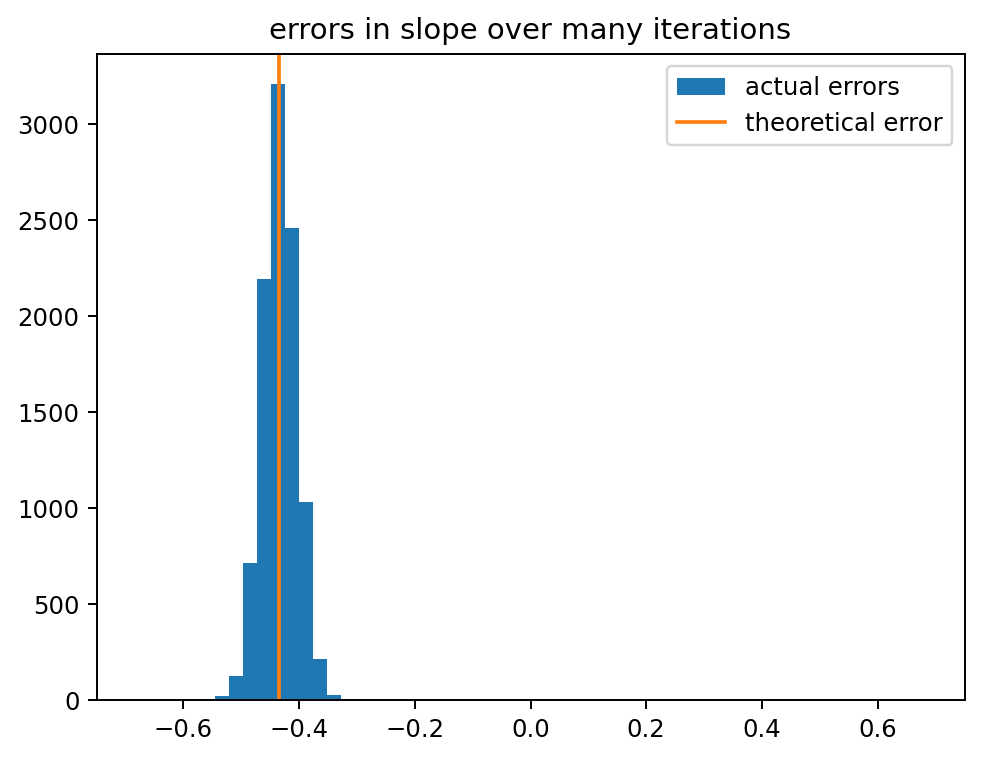

theoretical error = -0.43392
average error     = -0.4334239151850944


In [6]:
#---------------------------------------------------------------------------
LW = 1.75
rng = np.random.default_rng(SEED)  # set random seed to get reproducible results
N = 500  # number of samples
r_xy = -.35  # correlation of x and y noise
slope_true = 1.0  # slope of the true best fit line
sigma_y = 0.44  # amplitude of y-error
sigma_x = 0.75  # amplitude of x-error
std_X = 1.0  # spread of the noise-less x-values
niters = 10_000
#---------------------------------------------------------------------------

slope_vec = np.zeros((niters,))
york_vec = np.zeros((niters,))
for i in np.arange(0,niters):
    # DEFINE THE CORRELATED NOISE
    mean = [0, 0]
    cov = [[sigma_x**2, r_xy*sigma_x*sigma_y], [r_xy*sigma_x*sigma_y, sigma_y**2]]
    x_noise, y_noise = rng.multivariate_normal(mean, cov, N).T

    # CREATE TRUTH X DATA
    x = std_X*np.random.normal(size=N)
    x_obs = x + x_noise

    # ONLY Y HAS NOISE
    y = slope_true * x
    y_obs = y + y_noise

    # X AND Y BOTH HAVE UNCORRELATED NOISE
    slope_xynoise, intercept_noise, __, __, __ = stats.linregress(x_obs,y_obs)
    slope_vec[i] = slope_xynoise - slope_true

incorrect_slope = ((r_xy*sigma_x*sigma_y) / (std_X**2 + sigma_x**2) + slope_true*(std_X**2) / (std_X**2 + sigma_x**2))
theory_error = incorrect_slope - slope_true

plt.hist(slope_vec, label="actual errors")
plt.axvline(x=theory_error, color="tab:orange", label="theoretical error")
plt.title('errors in slope over many iterations')
plt.legend()
plt.xlim(-.75,.75)
plt.show()

print(f"theoretical error = {theory_error}")
print(f"average error     = {np.mean(slope_vec)}")

It works again!